In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsCV, LassoCV
from sklearn.model_selection import GridSearchCV
import warnings

In [3]:
def simulate_regression(n_samples, n_coeffs, sparsity=0.1, noise_std=1):
    beta = np.zeros(n_coeffs)
    sparsity_ratio = np.rint(n_coeffs*sparsity)
    indices = np.random.randint(0, n_coeffs, int(sparsity_ratio))
    for ind in indices:
        beta[ind] = np.random.normal()
    iids = [np.random.beta(2,5,(n_samples,1)) for _ in range(n_coeffs)]    
    X = np.concatenate(iids, axis=1)
    epsilon = np.random.normal(0, noise_std, (n_samples)) 
    y = np.matmul(beta, X.T) + epsilon
    return X, beta, y

In [46]:
sns.set()
X, beta, y = simulate_regression(60, 50, sparsity=0.1, noise_std=1)
non_zero_coeffs = beta[beta!=0]
A = np.where(beta != 0)


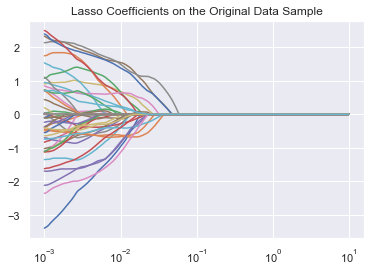

In [5]:
lasso_original = []
lasso_original_coeffs = []
for alpha in np.logspace(-3,1,200):
    lasso_original.append(Lasso(alpha=alpha).fit(X,y))
    lasso_original_coeffs.append(lasso_original[-1].coef_)

fig , ax = plt.subplots()
ax.plot(np.logspace(-3,1,200), lasso_original_coeffs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
ax.set_title('Lasso Coefficients on the Original Data Sample')
plt.axis('tight')
plt.savefig('Lasso Coefficients on the Original Data Sample')

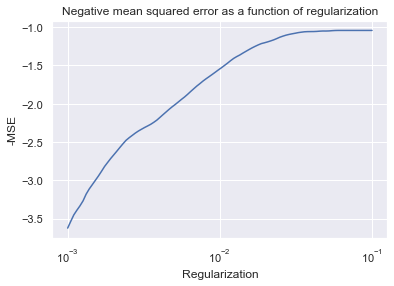

In [116]:
lasso_estimators = GridSearchCV(Lasso(), 
                                param_grid={'alpha': np.logspace(-3,-1,100)},
                                scoring='neg_mean_squared_error', cv=10).fit(X,y)

best_lasso_estimator = lasso_estimators.best_estimator_
beta_best_gscv_index = np.where(best_lasso_estimator.coef_ != 0)
plt.plot(np.logspace(-3,-1,100), lasso_estimators.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('Regularization')
plt.ylabel('-MSE')
plt.title('Negative mean squared error as a function of regularization')
plt.savefig('Negative mean squared error as a function of regularization')

In [94]:
# CV using the LARS algorithm
lasso_lars = LassoLarsCV(cv=10, ).fit(X, y)
beta_lars_index = np.where(lasso_lars.coef_ != 0)
print('Non-zero retrieved coeffs (using LARS algorithm) are: {}'.format(beta_lars_index[0]))
print('Non_zero retrieved coeffs (by tuning alpha) are: {}'.format(beta_best_gscv_index[0]))
print('True non_zero coeffs are: {}'.format(A[0]))

Non-zero retrieved coeffs (using LARS algorithm) are: [22]
Non_zero retrieved coeffs (by tuning alpha) are: []
True non_zero coeffs are: [ 9 13 16 24 43]


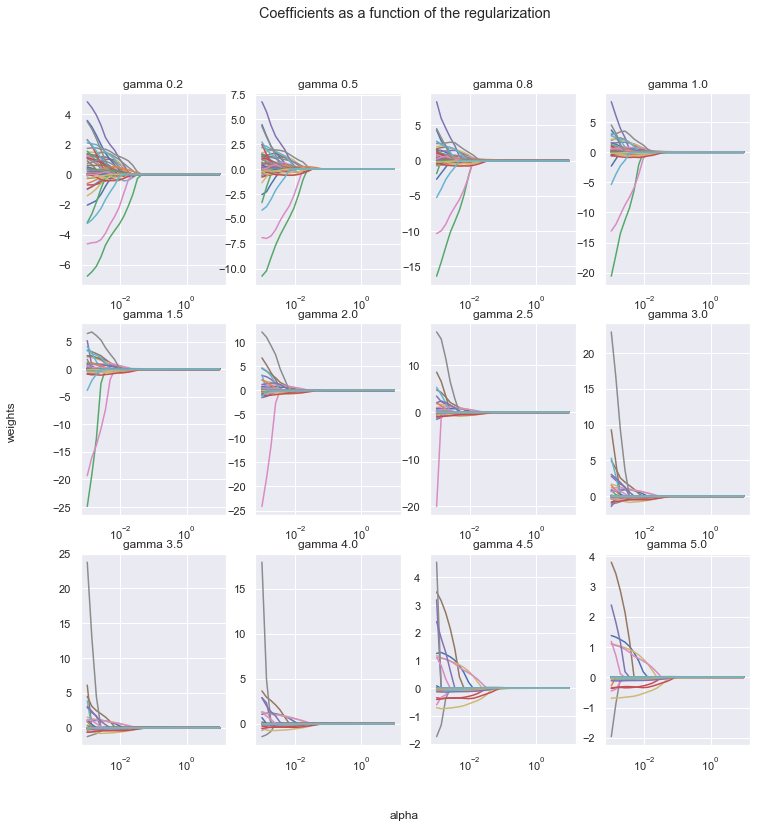

In [115]:
gamma = np.array([0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
lasso_clfs = [[] for _ in range(len(gamma))]
coefs = [[] for _ in range(len(gamma))]
fig = plt.figure(figsize=(12,12))
linreg = LinearRegression().fit(X, y)
weights=linreg.coef_

for i in range(len(gamma)): 
    X_prime = np.matmul(X, np.linalg.inv(np.diag(abs(weights)**gamma[i])))
    for j, alpha in enumerate(np.logspace(-3,1,30)):  
        lasso_clfs[i].append(Lasso(alpha=alpha))
        lasso_clfs[i][j].fit(X_prime, y)
        coefs[i].append(lasso_clfs[i][j].coef_)
    ax = fig.add_subplot(3,4,i+1)
    ax.plot(np.logspace(-3,1,30),coefs[i])
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()) 
    ax.set_title('gamma %.1f' %gamma[i])
    plt.axis('tight')
fig.text(0.5, 0.04, 'alpha', ha='center')
fig.text(0.04, 0.5, 'weights', va='center', rotation='vertical')
plt.suptitle('Coefficients as a function of the regularization')
plt.savefig('Alpha Regularization ex3')
plt.show()

        

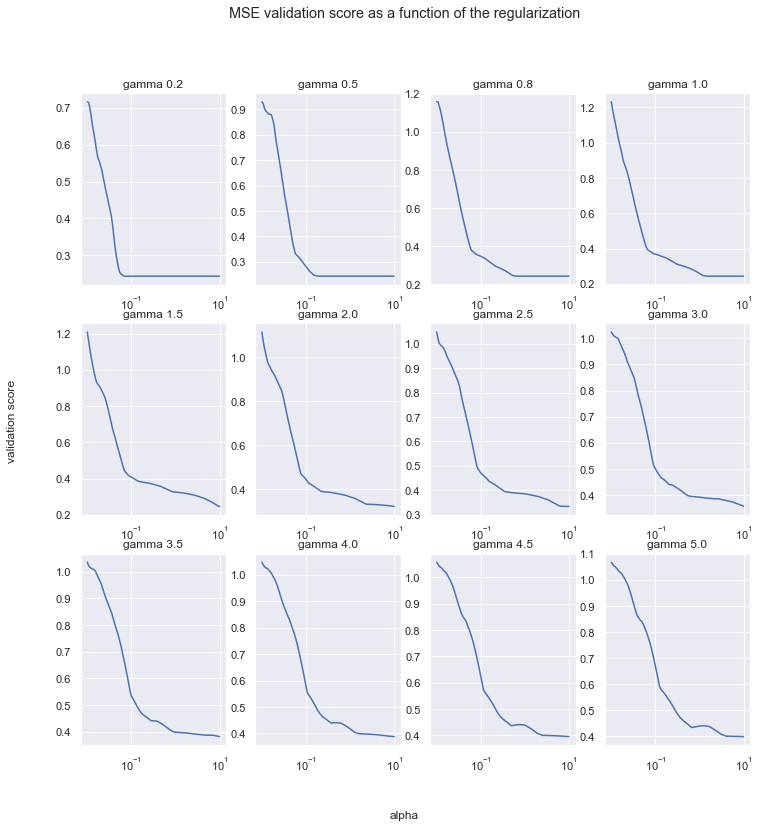

In [117]:
lasso_clfs_cv = []
fig = plt.figure(figsize=(12,12))
for i in range(len(gamma)):
    linreg = LinearRegression().fit(X, y)
    weights = linreg.coef_ 
    X_prime = np.matmul(X, np.linalg.inv(np.diag(abs(weights)**gamma[i])))
    lasso_clfs_cv.append(GridSearchCV(Lasso(), 
                         param_grid={'alpha': np.logspace(-2, 1, 100)},
                         scoring='r2').fit(X_prime, y))
    ax = fig.add_subplot(3,4,i+1)
    ax.plot(np.logspace(-2, 1, 100),abs(lasso_clfs_cv[i].cv_results_['mean_test_score']))
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()) 
    ax.set_title('gamma %.1f' %gamma[i])
    plt.axis('tight')
fig.text(0.5, 0.04, 'alpha', ha='center')
fig.text(0.04, 0.5, 'validation score', va='center', rotation='vertical')
plt.suptitle('MSE validation score as a function of the regularization')
plt.savefig('Alpha gridsearch ex3')
plt.show()

        

In [92]:
best_estimators = [lasso.best_estimator_ for lasso in lasso_clfs_cv]
lasso_coefficients = [lasso.coef_ for lasso in best_estimators]
adaptive_lasso_coefs = [np.matmul(np.linalg.inv(np.diag(abs(weights)**gamma[i])), 
                                  lasso_coefficients[i]) for i in range(len(gamma))]
beta_adalasso_indices = [np.where(ada != 0)[0] for ada in adaptive_lasso_coefs]
print(beta_adalasso_indices)
print('True coeffs: {}'.format(A[0]))

[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([42], dtype=int64), array([42], dtype=int64), array([42], dtype=int64), array([31, 42], dtype=int64), array([31, 42], dtype=int64), array([31, 42], dtype=int64), array([31, 37, 42], dtype=int64)]
True coeffs: [ 9 13 16 24 43]


In [21]:
linreg.coef_

array([-1.68427434, -1.88101881,  0.51260844, -1.41120031, -2.46724956,
        4.33046482,  1.23177021,  1.14914249, -0.14547402,  2.56371352,
       -4.59675678,  0.0855037 , -0.92393288,  0.42628713,  0.49927609,
       -1.98070412, -2.06211618,  0.99435062, -1.7739783 , -1.24378631,
       -1.10194894, -0.02283693, -0.94372867, -0.80179178, -1.99316449,
       -0.35706833,  0.06304232,  1.0487188 ,  1.66004415,  1.66755667,
        3.68887641, -1.09077692, -3.16380386,  3.6234368 , -0.86957597,
        1.04283404,  1.69404989,  3.69580872, -0.67718206, -0.50222695,
       -1.76615609,  1.93194823,  2.15720505, -1.48947375, -0.79605808,
       -1.18205551, -3.3405277 , -0.45917722,  0.27973227,  0.39080458])

In [128]:
warnings.filterwarnings('ignore')

n_samples = 600
repeats = 15

Xs = []
ys = []
betas = []
As = []
weights_list = []
lasso_clf_ensemble = []
adalasso_clf_ensemble = [[] for _ in range(repeats)]
adalasso_coef_ensemble = [[] for _ in range(repeats)]
best_lasso_ensemble = []
best_adalasso_ensemble = [[] for _ in range(repeats)]
lasso_coeff_ensemble = []
adalasso_coef_ensemble = []
beta_adalasso_indices = []
beta_prime_ensemble = []
retrieved_lasso_indices = []
coefs_beta_prime = [[] for _ in range(repeats)]

for i in range(repeats):
    dummy_X, dummy_beta, dummy_y = simulate_regression(n_samples, 50)
    Xs.append(dummy_X)
    ys.append(dummy_y)
    betas.append(dummy_beta)
    As.append(np.where(dummy_beta != 0)[0])
    linreg = LinearRegression().fit(dummy_X, dummy_y)
    weights_list.append(linreg.coef_)
    lasso_clf_ensemble.append(GridSearchCV(Lasso(),
                                           param_grid={'alpha': np.logspace(-3, 0, 50)},
                                           scoring='neg_mean_squared_error', cv=10).fit(dummy_X, dummy_y))
    best_lasso_ensemble.append(lasso_clf_ensemble[i].best_estimator_)
    lasso_coeff_ensemble.append(best_lasso_ensemble[i].coef_)
    retrieved_lasso_indices.append(np.where(lasso_coeff_ensemble[i] != 0)[0])
    for j in range(len(gamma)):
        X_primes = np.matmul(dummy_X, np.linalg.inv(np.diag(abs(weights_list[i]) ** gamma[j])))
        adalasso_clf_ensemble[i].append(GridSearchCV(Lasso(),
                                                     param_grid={'alpha': np.logspace(-3, 0, 50)},
                                                     scoring='neg_mean_squared_error', cv=10).fit(X_primes,
                                                                                                  dummy_y))
    best_adalasso_ensemble[i].append([lasso.best_estimator_ for lasso in adalasso_clf_ensemble[i]])
    coefs_beta_prime[i].append([best_adalasso_ensemble[i][0][j].coef_ for j in range(len(gamma))])

    adalasso_coef_ensemble.append([np.matmul(np.linalg.inv(np.diag(abs(weights_list[i]) ** gamma[j])),
                                             coefs_beta_prime[i][0][j]) for j in range(len(gamma))])
    beta_adalasso_indices.append([np.where(ada != 0)[0] for ada in adalasso_coef_ensemble[i]])


In [105]:
retrieved_lasso_indices

[array([19], dtype=int64), array([], dtype=int64)]

In [62]:
As

[array([17, 21, 33, 37, 46], dtype=int64),
 array([ 5, 24, 42, 45, 47], dtype=int64),
 array([ 2, 26, 36, 37, 38], dtype=int64),
 array([14, 23, 25, 44, 47], dtype=int64),
 array([ 3,  6, 12, 22, 48], dtype=int64),
 array([ 3,  5, 20, 22, 36], dtype=int64),
 array([ 7, 10, 12, 40, 43], dtype=int64),
 array([ 1,  2, 14, 35, 43], dtype=int64),
 array([ 1, 24, 37, 42, 46], dtype=int64),
 array([13, 23, 33, 40, 43], dtype=int64),
 array([ 4, 11, 19, 25, 34], dtype=int64),
 array([ 2,  3, 25, 33, 49], dtype=int64),
 array([14, 29, 32, 35, 44], dtype=int64),
 array([ 1, 26, 27, 28, 44], dtype=int64),
 array([15, 16, 18, 27, 32], dtype=int64)]

In [65]:
accuracy_retrieved_lasso

[array([], dtype=float64),
 array([], dtype=float64),
 array([5.2, 7.2, 7.4, 7.6])]

In [129]:
accuracy_retrieved_lasso = []
accuracy_retrieved_adalasso_ensemble = [[]for _ in range(repeats)]
accuracy_retrieved_adalasso = []
n_notintrue_lasso = []
n_notintrue_adalasso = [[] for _ in range(repeats)]
n_notintrue_adalasso_max = []
for i in range(repeats):
    accuracy_retrieved_lasso.append(len(np.intersect1d(As[i], retrieved_lasso_indices[i]))/len(As[i]))
    for j in range(len(gamma)):
        accuracy_retrieved_adalasso_ensemble[i].append(len(np.intersect1d(As[i], 
                                                                          beta_adalasso_indices[i][j]))/len(As[i]))
    accuracy_retrieved_adalasso.append(max(accuracy_retrieved_adalasso_ensemble[i]))

 
print(accuracy_retrieved_lasso)
print(accuracy_retrieved_adalasso)

[0.6, 0.8, 0.8, 1.0, 0.75, 0.6, 0.8, 0.8, 0.6, 0.6, 0.0, 1.0, 0.8, 1.0, 0.6]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [134]:
60, 80

lasso_ult_accs = [np.mean([0.6, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.8, 0.2, 0.2]), 
                  np.mean([0.4, 0.0, 0.4, 0.0, 0.8, 0.4, 0.4, 0.0, 0.0, 0.4, 0.0, 0.6, 0.2, 0.25, 0.0]),
                  np.mean([[0.8, 0.0, 0.4, 0.5, 0.6, 0.0, 0.0, 0.2, 0.6, 0.6, 0.2, 0.4, 0.0, 1.0, 0.5]]),
                  np.mean([0.8, 0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.4, 0.2, 0.4, 0.75, 1.0, 1.0, 0.8, 0.6]),
                  np.mean([0.6, 0.8, 0.8, 1.0, 0.75, 0.6, 0.8, 0.8, 0.6, 0.6, 0.0, 1.0, 0.8, 1.0, 0.6]),
                  np.mean([0.75, 1.0, 1.0, 0.6, 1.0, 0.4, 1.0, 1.0, 0.8, 0.8, 1.0, 0.8, 0.4, 1.0, 0.6])]

adalasso_ult_accs = [np.mean([0.0, 0.0, 0.4, 0.0, 0.2, 0.4, 0.75, 0.2, 0.6, 0.2, 0.0, 0.2, 0.4, 0.6, 0.4]),
                     np.mean([0.4, 0.0, 0.6, 0.25, 0.4, 0.2, 0.6, 0.0, 0.2, 0.2, 0.4, 0.6, 0.4, 0.25, 0.0]),
                     np.mean([[0.8, 0.6, 0.6, 0.5, 0.0, 0.4, 0.6, 0.4, 0.4, 0.2, 0.4, 0.4, 0.25, 1.0, 0.75]]),
                     np.mean([1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.4, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
                     1.0,
                     np.mean([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])]

print(lasso_ult_accs)
print(adalasso_ult_accs)

[0.16000000000000003, 0.2566666666666667, 0.3866666666666667, 0.5966666666666668, 0.7166666666666667, 0.81]
[0.29000000000000004, 0.30000000000000004, 0.4866666666666667, 0.88, 1.0, 1.0]


In [135]:
adalasso_ult_accs = [np.std([0.0, 0.0, 0.4, 0.0, 0.2, 0.4, 0.75, 0.2, 0.6, 0.2, 0.0, 0.2, 0.4, 0.6, 0.4]),
                     np.std([0.4, 0.0, 0.6, 0.25, 0.4, 0.2, 0.6, 0.0, 0.2, 0.2, 0.4, 0.6, 0.4, 0.25, 0.0]),
                     np.std([[0.8, 0.6, 0.6, 0.5, 0.0, 0.4, 0.6, 0.4, 0.4, 0.2, 0.4, 0.4, 0.25, 1.0, 0.75]]),
                     np.std([1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.4, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
                     1.0,
                     np.std([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])]

lasso_ult_accs = [np.std([0.6, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.8, 0.2, 0.2]), 
                  np.std([0.4, 0.0, 0.4, 0.0, 0.8, 0.4, 0.4, 0.0, 0.0, 0.4, 0.0, 0.6, 0.2, 0.25, 0.0]),
                  np.std([[0.8, 0.0, 0.4, 0.5, 0.6, 0.0, 0.0, 0.2, 0.6, 0.6, 0.2, 0.4, 0.0, 1.0, 0.5]]),
                  np.std([0.8, 0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.4, 0.2, 0.4, 0.75, 1.0, 1.0, 0.8, 0.6]),
                  np.std([0.6, 0.8, 0.8, 1.0, 0.75, 0.6, 0.8, 0.8, 0.6, 0.6, 0.0, 1.0, 0.8, 1.0, 0.6]),
                  np.std([0.75, 1.0, 1.0, 0.6, 1.0, 0.4, 1.0, 1.0, 0.8, 0.8, 1.0, 0.8, 0.4, 1.0, 0.6])]

print(lasso_ult_accs)
print(adalasso_ult_accs)

[0.2444040370643115, 0.24689178916188276, 0.30302181806302697, 0.22246098284618113, 0.23921166824012208, 0.21307275752662516]
[0.23395156193822114, 0.2024845673131659, 0.2425329301810833, 0.25086516962969035, 1.0, 0.0]
